In [239]:
import os
import pandas as pd
import numpy as np
from ast import literal_eval
%matplotlib inline
import matplotlib.pyplot as plt
from shutil import copyfile
from utils.visualization_utils import generic_plot, Curve, format_xtick, generic_sub_plot, Plot
from utils.data_utils import select_data
from learning_models.torch_sir import SirEq
import torch

In [159]:
exp_dir = os.path.join("regioni", "torch_sir_validation_grid_search")
best_path = os.path.join(os.getcwd(), exp_dir, "best")
if not os.path.exists(best_path):
    os.mkdir(best_path)

In [160]:
regions = [
    "Sardegna", 
    "P.A. Bolzano"
]

In [173]:
def get_scores_path(region):
    return os.path.join(exp_dir, region, "scores.csv")

def get_df(region):
    path = get_scores_path(region)
    df = pd.read_csv(path, sep="\t")
    return df[(df.use_alpha == False)]
    
def get_best_exp(df):
    return df[df.val_risk == df.val_risk.min()]

def print_best_exp_info(df):
    best_exp = get_best_exp(df)
    best_exp_name = best_exp.name.values[0]
    print(best_exp.val_risk)
    print(best_exp.test_risk)
    print(best_exp.dataset_risk)

    print(best_exp_name)

In [162]:
def compute_r0(df, t):
    df["r0_t" + str(t)] = df["final_beta_t" + str(t)] / df["final_gamma_t0"]
    
def get_list_from_column(df, raw_pos, column, max_size):
    col_val = df[column].iloc[raw_pos]
    x = literal_eval(col_val)
    return x +  [-1.0]*(max_size - len(x))

def get_res_parameters(scores_df, params=("beta", "gamma", "delta")):
    max_len = scores_df["train_size"].max()
    p_columns = ["final_" + p + "_t" + str(i) for p in params for i in range(max_len)]
    score_columns = list(set(scores_df.columns) - set(params))
    #     params_df.at[:, score_columns] = scores_df.loc[:, score_columns] # copies everything in the first columns
    
    rows = []
    for i in range(scores_df.shape[0]):
        # create rows
        values = []
        for p in params:
            val = get_list_from_column(scores_df, i, p, max_len)
            values.extend(val)
        rows.append(list(scores_df.iloc[i][score_columns]) + values)
        
    
    params_df = pd.DataFrame(rows, columns=score_columns + p_columns)
    
    for p in p_columns:
        #print(params_df[p])
        params_df.loc[params_df[p] == -1, p] = None

    for t in range(max_len):
        compute_r0(params_df, t)
    
    return params_df, p_columns

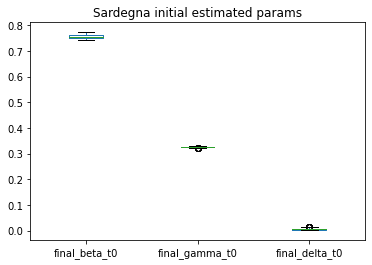

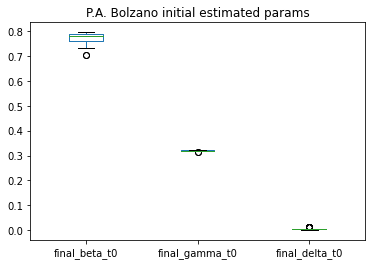

In [163]:
for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    params_df[["final_beta_t0", "final_gamma_t0", "final_delta_t0"]].plot.box(title=region +" initial estimated params")

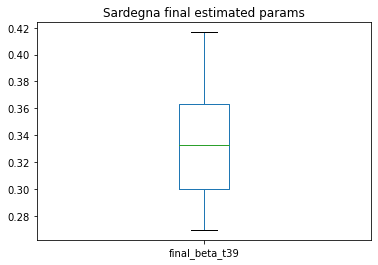

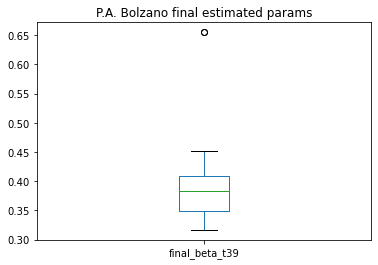

In [164]:

for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    params_df[["final_beta_t39"]].plot.box(title=region + " final estimated params")

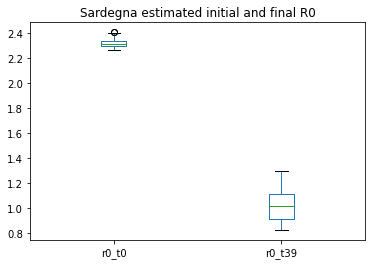

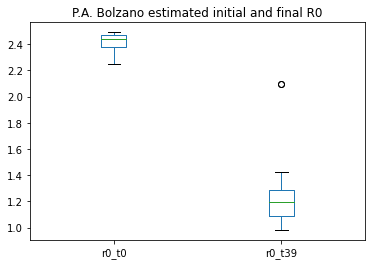

In [165]:
for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    params_df[["r0_t0", "r0_t39"]].plot.box(title=region +" estimated initial and final R0")

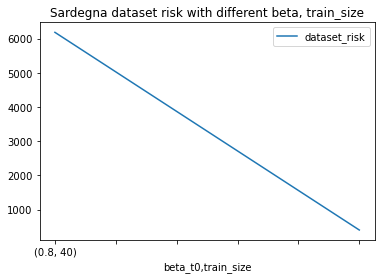

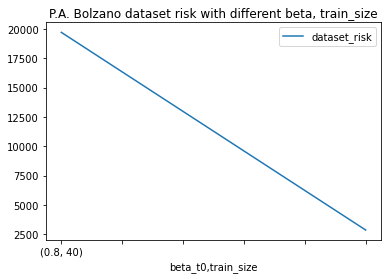

In [166]:
for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    params_df.groupby(["beta_t0","train_size"])[["dataset_risk"]].mean().plot(title=region + " dataset risk with different beta, train_size", legend=True)

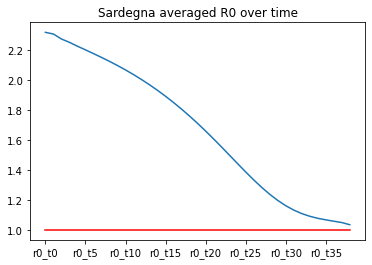

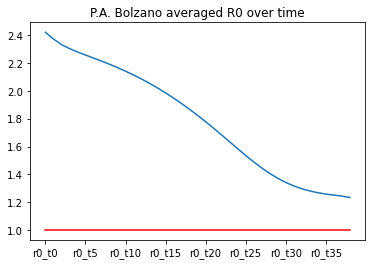

In [175]:
for region in regions:
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    fig, ax = plt.subplots()
    r0_cols = ["r0_t"+ str(t) for t in range(39)]
    ax.plot([1.0]*len(r0_cols), '-r')
    params_df[r0_cols].mean().plot(ax=ax, title=region + " averaged R0 over time")

S_b0.8_g0.3_d0.02_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der100000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
P_b0.8_g0.3_d0.02_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der20000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0


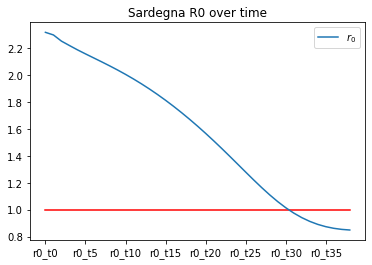

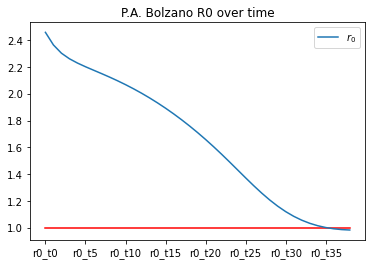

In [176]:
for region in regions:
    # R0 of single experiment
    df = get_df(region)
    params_df, p_columns = get_res_parameters(df)
    exp_id = params_df.val_risk.idxmin()
    print(params_df.iloc[exp_id]["name"])
    r0_cols = ["r0_t"+ str(t) for t in range(39)]
    fig, ax = plt.subplots()
    ax.plot([1.0]*len(r0_cols), '-r')
    params_df[r0_cols].iloc[exp_id].plot(ax=ax, label="$r_0$", legend=True, title=region + " R0 over time")
    plt.savefig(os.path.join(best_path, f"{region}_r0.png"), transparent=True)

In [235]:
populations = {
        "Lombardia": 1e7, 
        "Emilia-Romagna": 4.45e6, 
        "Veneto": 4.9e6, 
        "Piemonte": 4.36e6,
        "Toscana": 3.73e6, 
        "Umbria": 0.882e6, 
        "Marche": 1.525e6, 
        "Campania": 5.802e6,
        "Puglia": 1.551e6, 
        "Liguria": 4.029e6,
        "P.A. Bolzano": 5.209e5,
        "P.A. Trento": 5.414e5,
        "Valle d'Aosta": 1.257e5,
        "Sicilia": 5e6,
        "Sardegna": 1.64e6,
        "Abruzzo": 1.312e6,
        "Lazio": 5.879e6,
}

In [229]:
def get_target(region):
    df_path = os.path.join(os.getcwd(), "COVID-19", "dati-regioni", "dpc-covid19-ita-regioni.csv")
    area = [region]  # list(df["denominazione_regione"].unique())
    area_col_name = "denominazione_regione"  # "Country/Region"
    value_col_name = "deceduti"  # "Fatalities"
    groupby_cols = ["data"]  # ["Date"]
    x_target, w_target = select_data(df_path, area, area_col_name, value_col_name, groupby_cols, file_sep=",")
    _, y_target = select_data(df_path, area, area_col_name, "totale_positivi", groupby_cols, file_sep=",")
    
    tmp_y, tmp_w = [], []
    for i in range(len(y_target)):
        if y_target[i] > 0:
            tmp_y.append(y_target[i])
            tmp_w.append(w_target[i])
    y_target = tmp_y
    w_target = tmp_w
    return w_target, y_target 

    

In [ ]:
w_hat, y_hat, sol = sir.inference(torch.arange(dy_params["t_start"], 100, t_inc))

train_slice = slice(dy_params["t_start"], int(train_size/t_inc), int(1/t_inc))
val_slice = slice(int(train_size/t_inc), int(val_size/t_inc), int(1/t_inc))
test_slice = slice(int(val_size/t_inc), int(dataset_size/t_inc), int(1/t_inc))
dataset_slice = slice(dy_params["t_start"], int(dataset_size/t_inc), int(1/t_inc))

w_hat_train, w_hat_val, w_hat_test = w_hat[train_slice], w_hat[val_slice], w_hat[test_slice]
w_hat_dataset = w_hat[dataset_slice]
y_hat_train, y_hat_val, y_hat_test = y_hat[train_slice], y_hat[val_slice], y_hat[test_slice]
y_hat_dataset = y_hat[dataset_slice]

train_risk, train_w_risk, train_y_risk, _ = sir.loss(w_hat_train, w_target[dy_params["t_start"]:train_size],
                                                     y_hat_train, y_target[dy_params["t_start"]:train_size])

validation_risk, validation_w_risk, validation_y_risk, _ = sir.loss(w_hat_val, w_target[dy_params["t_end"]:val_size],
                                                                    y_hat_val, y_target[dy_params["t_end"]:val_size])

test_risk, test_w_risk, test_y_risk, _ = sir.loss(w_hat_test, w_target[val_size:dataset_size],
                                                  y_hat_test, y_target[val_size:dataset_size])

dataset_risk, _, _, _ = sir.loss(w_hat_dataset, w_target[dy_params["t_start"]:dataset_size],
                                 y_hat_dataset, y_target[dy_params["t_start"]:dataset_size])

In [233]:
def print_bcd(sir, train_size):
    pl_x = list(range(train_size))  # list(range(len(beta)))
    beta_pl = Curve(pl_x, sir.beta.detach().numpy(), '-g', "$\\beta$")
    gamma_pl = Curve(pl_x, [sir.gamma.detach().numpy()]*train_size, '-r', "$\gamma$")
    delta_pl = Curve(pl_x, [sir.delta.detach().numpy()]*train_size, '-b', "$\delta$")
    params_curves = [beta_pl, gamma_pl, delta_pl]
    bgd_pl_title = "$\\beta, \gamma, \delta$  ({}".format(str(area[0])) + str(")")
    bgd_pl_path = os.path.join(exp_path, exp_prefix + "_bcd_over_time" + file_format)
    fig = generic_plot(params_curves, bgd_pl_title, bgd_pl_path, formatter=format_xtick)

In [238]:
for region in regions:
    df = get_df(region)
    best_exp = get_best_exp(df).iloc[0]
    beta = literal_eval(best_exp["beta"])
    gamma = literal_eval(best_exp["gamma"]) * len(beta)
    delta = literal_eval(best_exp["delta"]) * len(beta)
    train_size = best_exp["train_size"]
    val_len = best_exp["val_size"]
    t_inc = best_exp["t_inc"]
    population = populations[region]
    
    w_target, y_target = get_target(region)
    
    val_size = min(train_size + val_len, len(w_target) - 5)  # validation on the next val_len days (or less if we have less data)
    dataset_size = len(w_target)
    exp_prefix = region + "_best"
    
    dy_params = {"t_start": 0, "t_end": train_size}
    
    # init parameters
    epsilon = y_target[0].item() / population
    epsilon_z = w_target[0].item() / population
    S0 = 1 - (epsilon + epsilon_z)
    I0 = epsilon
    S0 = S0 * population
    I0 = I0 * population
    Z0 = epsilon_z

    init_cond = (S0, I0, Z0)  # initialization of SIR parameters (Suscettible, Infected, Recovered)
    sir = SirEq(beta, gamma, delta, population, init_cond=init_cond)
    
    w_hat, y_hat, sol = sir.inference(torch.arange(dy_params["t_start"], 100, t_inc))
    
    train_slice = slice(dy_params["t_start"], int(train_size/t_inc), int(1/t_inc))
    val_slice = slice(int(train_size/t_inc), int(val_size/t_inc), int(1/t_inc))
    test_slice = slice(int(val_size/t_inc), int(dataset_size/t_inc), int(1/t_inc))
    dataset_slice = slice(dy_params["t_start"], int(dataset_size/t_inc), int(1/t_inc))

    w_hat_train, w_hat_val, w_hat_test = w_hat[train_slice], w_hat[val_slice], w_hat[test_slice]
    w_hat_dataset = w_hat[dataset_slice]
    y_hat_train, y_hat_val, y_hat_test = y_hat[train_slice], y_hat[val_slice], y_hat[test_slice]
    y_hat_dataset = y_hat[dataset_slice]

    train_risk, train_w_risk, train_y_risk, _ = sir.loss(w_hat_train, w_target[dy_params["t_start"]:train_size],
                                                         y_hat_train, y_target[dy_params["t_start"]:train_size])

    validation_risk, validation_w_risk, validation_y_risk, _ = sir.loss(w_hat_val, w_target[dy_params["t_end"]:val_size],
                                                                        y_hat_val, y_target[dy_params["t_end"]:val_size])

    test_risk, test_w_risk, test_y_risk, _ = sir.loss(w_hat_test, w_target[val_size:dataset_size],
                                                      y_hat_test, y_target[val_size:dataset_size])

    dataset_risk, _, _, _ = sir.loss(w_hat_dataset, w_target[dy_params["t_start"]:dataset_size],
                                     y_hat_dataset, y_target[dy_params["t_start"]:dataset_size])
    
    


NameError: name 'torch' is not defined

In [177]:
for region in regions:
    df = get_df(region)
    print_best_exp_info(df)

59    7.816322
Name: val_risk, dtype: float64
59    45.925426
Name: test_risk, dtype: float64
59    14.110578
Name: dataset_risk, dtype: float64
S_b0.8_g0.3_d0.02_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der100000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
58    3.808903
Name: val_risk, dtype: float64
58    246.77562
Name: test_risk, dtype: float64
58    91.88786
Name: dataset_risk, dtype: float64
P_b0.8_g0.3_d0.02_lrb0.0001_lrg1e-05_lrd3e-06_lra0.001_ts45_vl10_st_der20000.0_nd_der0_t_inc0.1_use_alphaFalse_y_loss_weight0.0
